In [116]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

warnings.filterwarnings('ignore')
%matplotlib inline

### **1. Data Preparation**

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [2]:
# download the dataset
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -O housing.csv

--2023-10-23 22:11:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3%  404K 3s
    50K .......... .......... .......... .......... ..........  7% 4.45M 2s
   100K .......... .......... .......... .......... .......... 10%  682K 2s
   150K .......... .......... .......... .......... .......... 14%  614K 2s
   200K .......... .......... .......... .......... .......... 17%  641K 2s
   250K .......... .......... .......... .......... .......... 21%  790K 2s
   300K .......... .......... .......... .......... .......... 25% 1.52M 1s
   350K .......... .......... ..

In [3]:
# load the dataset
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# examine the shape of the dataset
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

There are 20640 rows and 10 columns


In [5]:
# filter the dataset by ocean_proximity
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df = df.reset_index(drop=True)

In [6]:
# examine the basic information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15687 entries, 0 to 15686
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


In [7]:
# check the shape of the filtered dataset
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns for the filtered dataset")

There are 15687 rows and 10 columns for the filtered dataset


### **2. Explaratory Data Analysis**

In [8]:
# check the null values
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
# fill the null values by 0
df['total_bedrooms'] = df['total_bedrooms'].fillna(0)

In [10]:
# check the null values
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [11]:
# define the numerical and categorical columns
numerical_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns

In [12]:
# examine the descriptive statistics of numerical columns
df.describe().round(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,15687.000,15687.000,15687.000,15687.000,15687.000,15687.000,15687.000,15687.000,15687.000
mean,-119.217,35.467,27.188,2665.677,535.828,1466.317,500.916,3.804,191943.020
std,1.780,2.066,12.057,2257.673,436.800,1180.390,392.759,1.857,108801.078
min,-124.140,32.610,1.000,2.000,0.000,3.000,2.000,0.500,14999.000
25%,-121.070,33.940,17.000,1441.000,291.000,802.000,278.000,2.521,111300.000
50%,-118.370,34.160,27.000,2118.000,429.000,1195.000,406.000,3.469,166900.000
75%,-117.990,37.340,36.000,3172.000,642.000,1777.000,602.000,4.686,241100.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


In [13]:
# examine the descriptive statistics of categorical_column
df[categorical_columns].describe().T

,count,unique,top,freq
ocean_proximity,15687,2,<1H OCEAN,9136


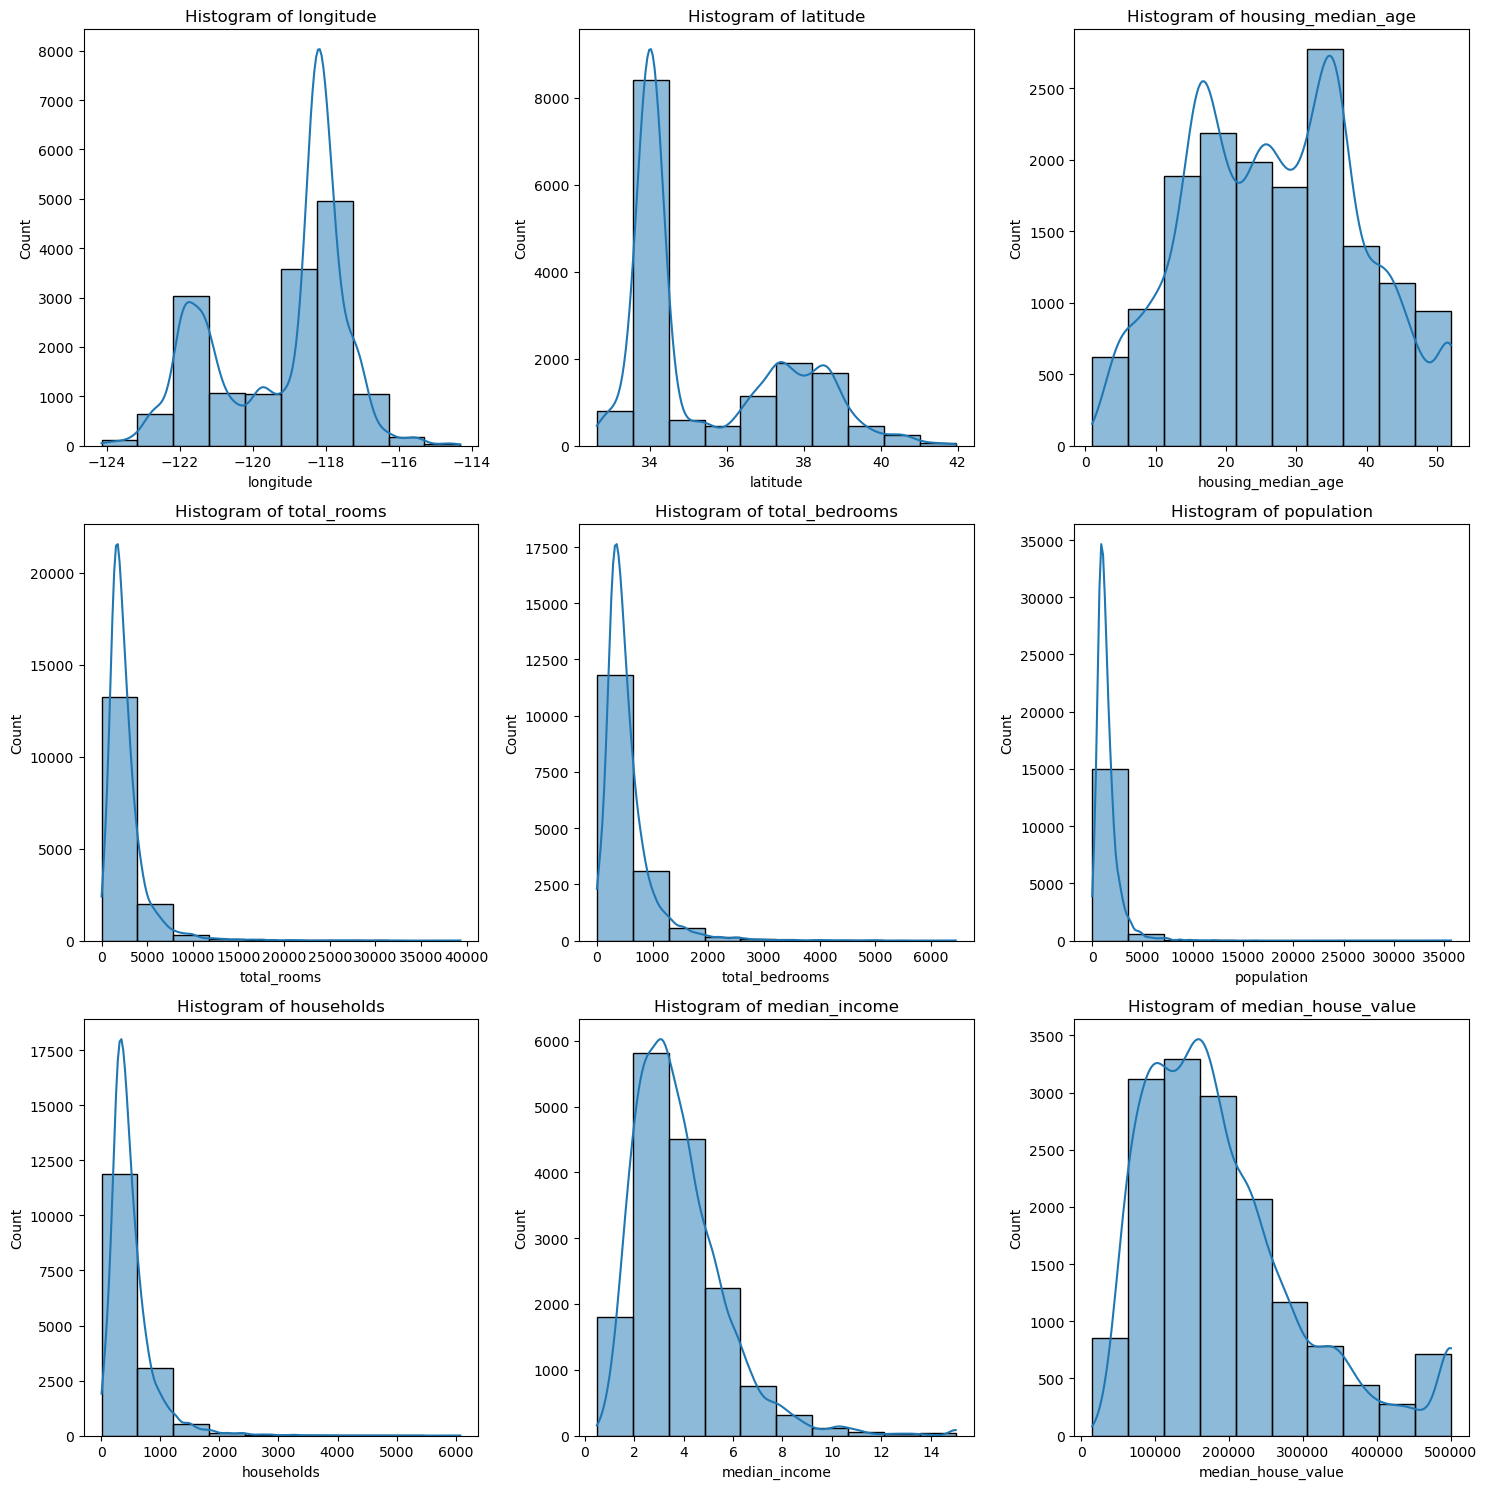

In [14]:
# create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# flatten the axes array for easier iteration
axes = axes.flatten()

# loop through each column and create a histogram
for i, col in enumerate(numerical_columns):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=10)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)

# adjust layout to prevent overlap
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix')

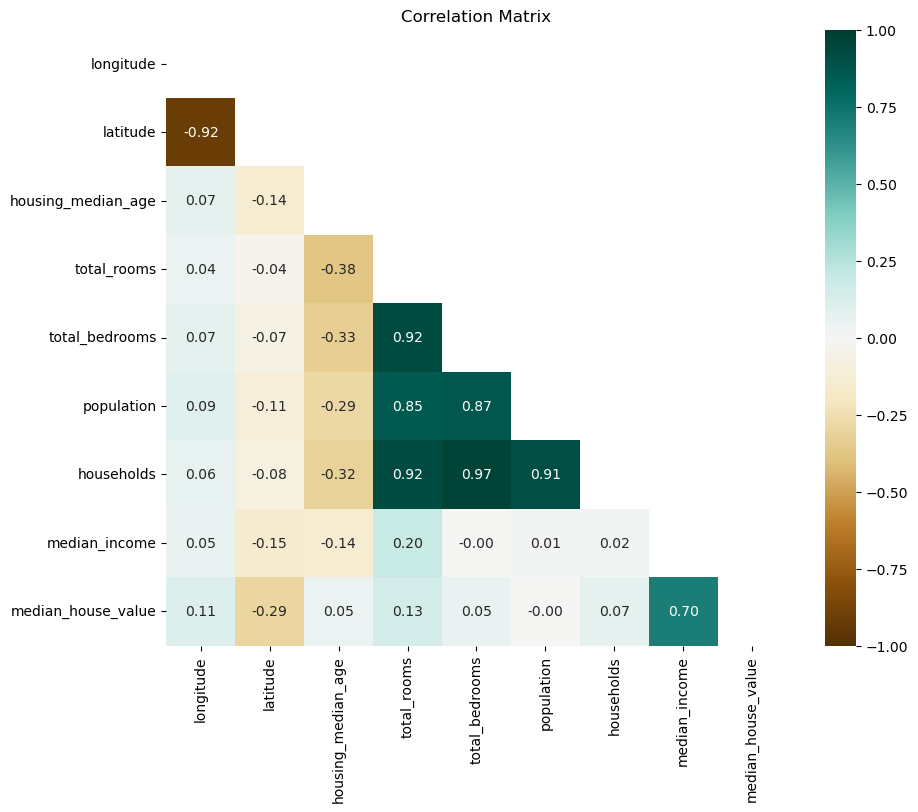

In [15]:
# calculate the correlation matrix
corr_matrix = df[numerical_columns].corr()


# create a mask to hide the upper triangle of the matrix (optional but recommended)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="BrBG", vmin=-1, vmax=1, mask=mask)

# set the title
plt.title("Correlation Matrix")

Text(0.5, 1.0, 'Countplot of ocean_proximity')

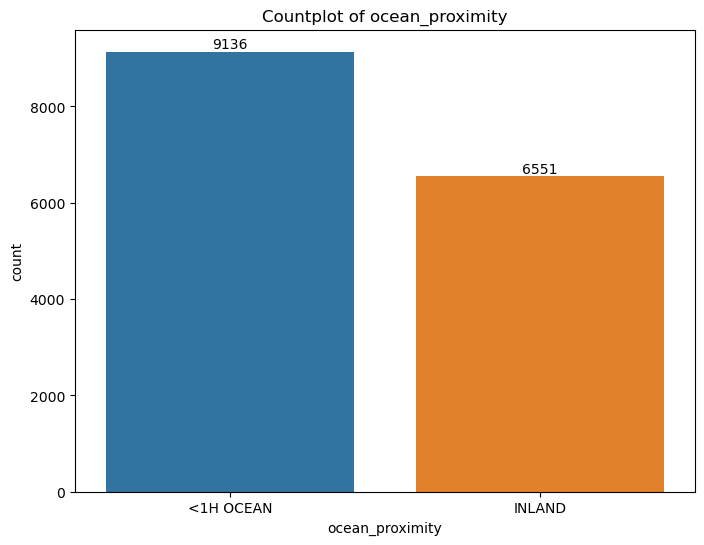

In [158]:
# create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='ocean_proximity', data=df)
# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# set the title
plt.title('Countplot of ocean_proximity')

In [17]:
# log transformation for median_house_value
df['median_house_value'] = np.log1p(df['median_house_value'])

Text(0.5, 0, 'median_house_value')

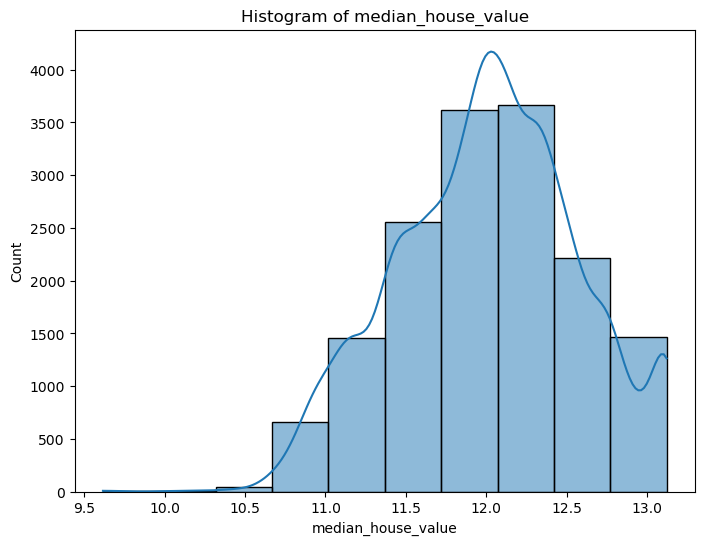

In [159]:
# create a histogram for tranformed median_house_value
plt.figure(figsize=(8, 6))
sns.histplot(x='median_house_value', data=df, kde=True, bins=10)
plt.title('Histogram of median_house_value')
plt.xlabel('median_house_value')

### **3. Setting up the Validation Framework**

In [160]:
# split the dataset in train/val/test sets with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# the test size uses 0.25 derived from 20%(val)/80%(full_train) since the validation distribution is 20% of full dataset
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Make sure that the distributions are correct with the total of observations
assert len(df) == (len(df_train) + len(df_val) + len(df_test))

In [22]:
# reset the index of datasets
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [24]:
# extract the target values
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

In [25]:
# drop the target column from the datasets
df_train.drop(columns='median_house_value', inplace=True)
df_val.drop(columns='median_house_value', inplace=True)
df_test.drop(columns='median_house_value', inplace=True)

In [27]:
# set up DictVectorizer
dv = DictVectorizer(sparse=False)

In [28]:
# convert the datasets into dictionaries
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')

In [29]:
# fit the DictVectorizer on the training dataset
dv.fit(dicts_train)

DictVectorizer(sparse=False)

In [31]:
# transform each datasets using the fitted DictVectorizer
X_train = dv.transform(dicts_train)
X_val = dv.transform(dicts_val)
X_test = dv.transform(dicts_test)

In [34]:
# extract the features_names from the fitted DictVectorizer
features_names = dv.feature_names_
features_names

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

### **4. Modelling**

Question 1: Let's train a decision tree regressor to predict the median_house_value variable.
- Train a model with max_depth=1.

**Which feature is used for splitting the data?**
- ocean_proximity
- total_rooms
- latitude
- population

In [37]:
# train a decision tree regressor model
dtr_model = DecisionTreeRegressor(max_depth=1)
dtr_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [41]:
# extract a feature that is used for splitting the data
print(export_text(dtr_model, feature_names = features_names))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Answer: *The ocean_promixity feature is used for splitting the data*

Question 2: Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

**What's the RMSE of this model on validation?**
- 0.045
- 0.245
- 0.545
- 0.845

In [45]:
# train a decision tree regressor model by n_estimator parameter
rfr_model = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [50]:
# use the model to predict on the validation dataset
y_pred = rfr_model.predict(X_val)
y_pred

array([12.19234146, 12.13600559, 11.58298397, ..., 11.7062094 ,
       11.25705593, 11.62903578])

In [53]:
# calculate the RMSE of the model on the validation dataset
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"The RMSE on validation dataset: {rmse:.3f}")

The RMSE on validation dataset: 0.245


Answer: *The RMSE on validation dataset: 0.245*

Question 3: Now let's experiment with the n_estimators parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

**After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.**
- 10
- 25
- 50
- 160

In [168]:
# conduct a model tuning to find the best parameter of n_estimators
n_estimators = range(10, 201, 10)
evaluations = []

for n in n_estimators:
    rfr_model = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
    rfr_model.fit(X_train, y_train)

    y_pred = rfr_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(3)

    evaluations.append((n, rmse))

In [169]:
evaluations

[(10, 0.245),
 (20, 0.238),
 (30, 0.236),
 (40, 0.235),
 (50, 0.235),
 (60, 0.234),
 (70, 0.234),
 (80, 0.234),
 (90, 0.234),
 (100, 0.234),
 (110, 0.234),
 (120, 0.234),
 (130, 0.234),
 (140, 0.234),
 (150, 0.234),
 (160, 0.233),
 (170, 0.233),
 (180, 0.234),
 (190, 0.234),
 (200, 0.234)]

In [170]:
# create a dataframe for n_estimators evaluation
df_evaluations = pd.DataFrame(evaluations, columns=['n_estimators', 'rmse'])
df_evaluations.sort_values(by='rmse', ascending=False).head()

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.236
3,40,0.235
4,50,0.235


Text(0.5, 1.0, 'Performance evaluation of n_estimators parameter')

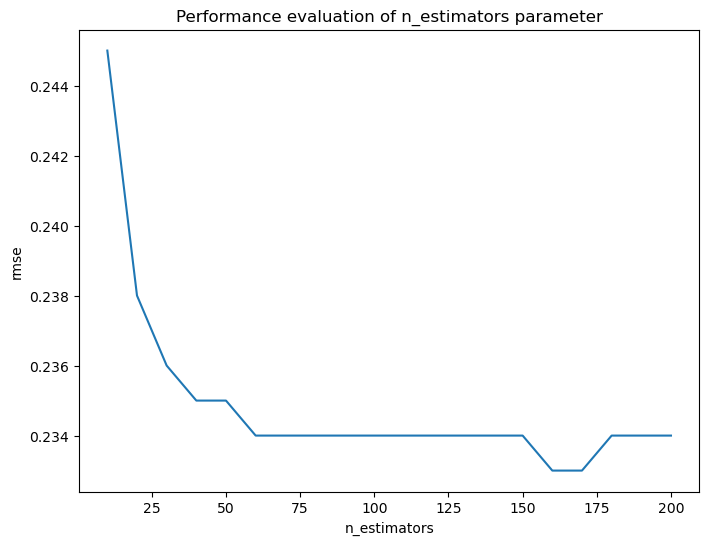

In [172]:
# create a line chart of performance evaluation of n_estimators parameter
plt.figure(figsize=(8, 6))
plt.plot(df_evaluations['n_estimators'], df_evaluations['rmse'])
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.title('Performance evaluation of n_estimators parameter')

Answer: *RMSE stop improving after n_estimators=50*

Question 4: Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10), calculate the mean RMSE
- Fix the random seed: random_state=1

**What's the best max_depth, using the mean RMSE?**
- 10
- 15
- 20
- 25

In [67]:
# conduct a model tuning to find the best parameter of n_estimators and max_depth
n_estimators = range(10, 201, 10)
max_depth = [10, 15, 20, 25]
evaluations = []

for n in n_estimators:
    for md in max_depth:
        rdr_model = RandomForestRegressor(n_estimators=n, max_depth=md, n_jobs=-1, random_state=1)
        rdr_model.fit(X_train, y_train)

        y_pred = rdr_model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(3)

        evaluations.append((n, md, rmse))

In [68]:
# create a dataframe for n_estimators and max_depth evaluation
df_evaluations = pd.DataFrame(evaluations, columns=['n_estimators', 'max_depth', 'rmse'])
df_evaluations.sort_values(by='rmse', ascending=False).head()

,n_estimators,max_depth,rmse
0,10,10,0.251
4,20,10,0.247
20,60,10,0.246
28,80,10,0.246
32,90,10,0.246


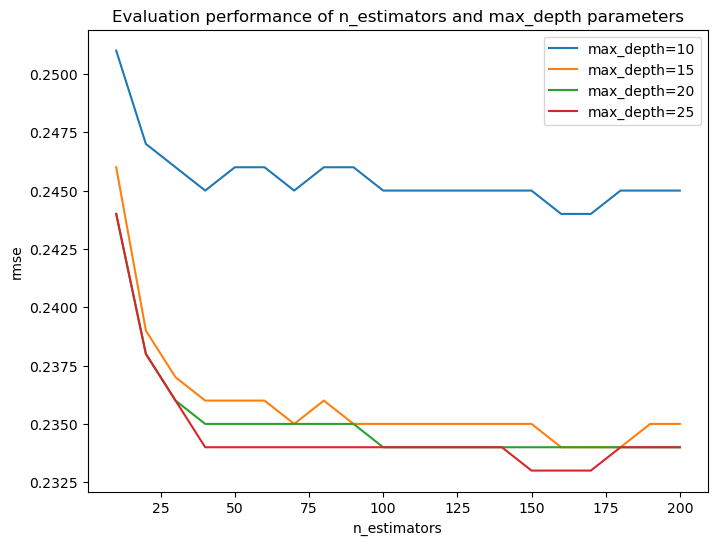

In [72]:
# create a line chart of performance evaluation of n_estimators and max_depth parameters
plt.figure(figsize=(8, 6))
for md in max_depth:
    df_subset = df_evaluations[df_evaluations['max_depth'] == md]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label='max_depth=%d' %md)

plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.title('Performance evaluation of n_estimators and max_depth parameters')
plt.legend()

In [75]:
# calculate the mean of max_depth
df_evaluations.groupby('max_depth')['rmse'].mean()

max_depth
10    0.24555
15    0.23590
20    0.23510
25    0.23465
Name: rmse, dtype: float64

Answer: *The best max_depth based on the mean of RMSE: 25*

Question 5: We can extract feature importance information from tree-based models.
At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:
1. Train the model with these parameters:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

2. Get the feature importance information from this model

**What's the most important feature (among these 4)?**

- total_rooms
- median_income
- total_bedrooms
- longitude

In [76]:
# train a decision tree regressor model
rdr_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rdr_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [112]:
# extract the feature importances from the model
feature_importances = list(zip(features_names, rdr_model.feature_importances_))
importance_df = pd.DataFrame(feature_importances, columns=['feature_names', 'feature_importances'])

In [114]:
# sort descending the dataframe by using feature_importances value
importance_df = importance_df.sort_values(by='feature_importances', ascending=False)

Text(0.5, 1.0, 'Feature Importance Chart')

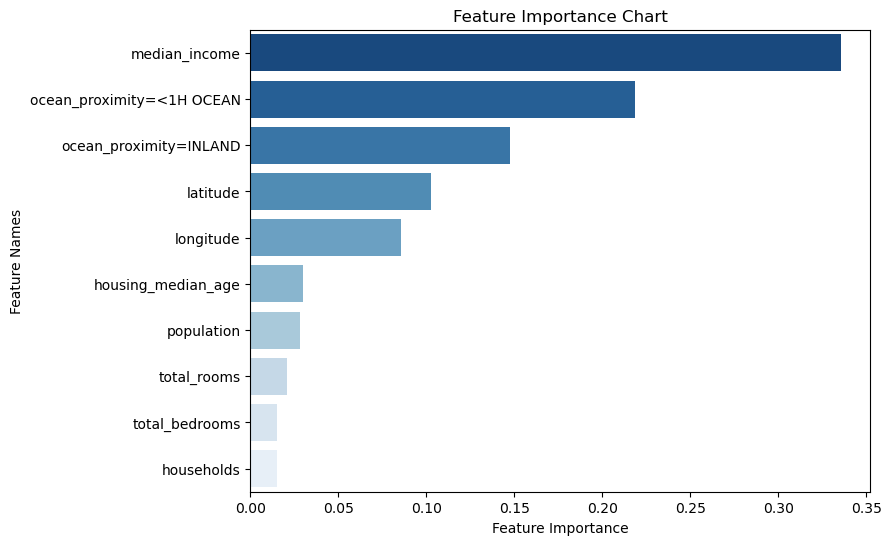

In [115]:
# create a horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='feature_importances', y='feature_names', data=importance_df, palette='Blues_r')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Chart')

Answer: *The most important feature is median_income*

Question 6: Now let's train an XGBoost model! For this question, we'll tune the eta parameter:
- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?
- 0.3
- 0.1
- Both give equal value

In [123]:
# examine the features_names
features_names

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [124]:
# change the features_names with index 5 to avoid error for XGBoost Model
features_names[5] = 'ocean_proximity less than or equal to 1H OCEAN'
features_names

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity less than or equal to 1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [125]:
# create DMatrix for the train and validation datasets
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_names)

In [151]:
# define variables for eta, dataframe results, watchlist, xgb_parameters, and evaluation results
eta_values = [0.1, 0.3]
results_df = pd.DataFrame(columns=['eta', 'iteration', 'train_rmse', 'val_rmse'])
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
evals_result = {}

In [152]:
# loop through the 'eta' values and train the model
for eta in eta_values:
    xgb_params = xgb_params.copy()  # copy common parameters
    xgb_params['eta'] = eta  # modify 'eta' parameter

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, evals_result=evals_result)
        
    # extract evaluation results
    train_rmse = evals_result['train']['rmse']
    val_rmse = evals_result['val']['rmse']

    # create a DataFrame for the current evaluation results
    eval_df = pd.DataFrame({
        'eta': [eta] * len(train_rmse),
        'iteration': range(1, len(train_rmse) + 1),
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    })

    # concatenate the current evaluation results to the results DataFrame
    results_df = pd.concat([results_df, eval_df], ignore_index=True)

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269
[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	va

[25]	train-rmse:0.23026	val-rmse:0.25997
[26]	train-rmse:0.22720	val-rmse:0.25799
[27]	train-rmse:0.22487	val-rmse:0.25620
[28]	train-rmse:0.22268	val-rmse:0.25494
[29]	train-rmse:0.22084	val-rmse:0.25374
[30]	train-rmse:0.21887	val-rmse:0.25266
[31]	train-rmse:0.21709	val-rmse:0.25172
[32]	train-rmse:0.21505	val-rmse:0.25075
[33]	train-rmse:0.21342	val-rmse:0.24991
[34]	train-rmse:0.21168	val-rmse:0.24882
[35]	train-rmse:0.21020	val-rmse:0.24826
[36]	train-rmse:0.20878	val-rmse:0.24779
[37]	train-rmse:0.20755	val-rmse:0.24731
[38]	train-rmse:0.20625	val-rmse:0.24668
[39]	train-rmse:0.20518	val-rmse:0.24624
[40]	train-rmse:0.20392	val-rmse:0.24539
[41]	train-rmse:0.20285	val-rmse:0.24501
[42]	train-rmse:0.20172	val-rmse:0.24435
[43]	train-rmse:0.20045	val-rmse:0.24380
[44]	train-rmse:0.19900	val-rmse:0.24311
[45]	train-rmse:0.19814	val-rmse:0.24293
[46]	train-rmse:0.19628	val-rmse:0.24184
[47]	train-rmse:0.19561	val-rmse:0.24159
[48]	train-rmse:0.19464	val-rmse:0.24131
[49]	train-rmse:

In [156]:
# display the results dataframe
results_df.head()

,eta,iteration,train_rmse,val_rmse
0,0.1,1,0.524490,0.520447
1,0.1,2,0.487359,0.484430
2,0.1,3,0.454328,0.452930
3,0.1,4,0.425333,0.425497
4,0.1,5,0.399872,0.401439


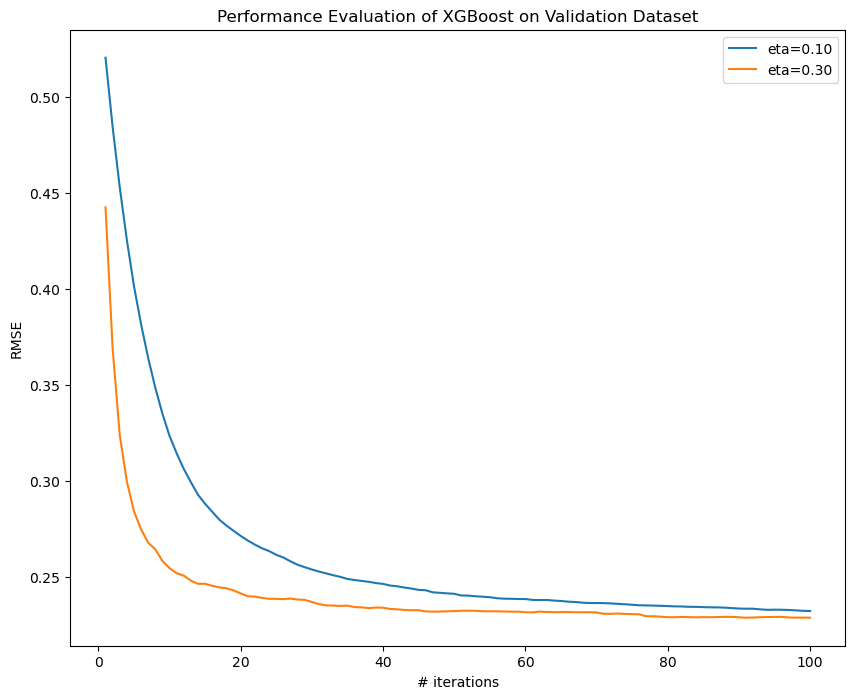

In [157]:
# create a line chart
plt.figure(figsize=(10, 8))
for eta in eta_values:
    df_subset = results_df[results_df['eta'] == eta]
    plt.plot(df_subset['iteration'], df_subset['val_rmse'], label='eta=%.2f' %eta)

plt.xlabel('# iterations')
plt.ylabel('RMSE')
plt.title('Performance Evaluation of XGBoost on Validation Dataset')
plt.legend()

Answer: *eta=0.3 leads to the best RMSE score on the validation dataset*